사진에 나온 미국동전 합계를 계산하는 프로그램을 작성해 본다. [^skimage-coins]

[^skimage-coins]: [Materials for a 90 minute workshop "Image Analysis in Python"](https://github.com/brikeats/Image-Analysis-in-Python)

<img src="fig/quarters_dimes_pennies.png" alt="미국동전 이미지 합계 계산" width="30%">

### 1. 이미지를 불러와서 흑백으로 변환

로컬 저장소에 저장된 `quarters_dimes_pennies.png` 이미지 파일을 불러와서 흑백으로 전환하고 원본 이미지와 더불어 흑백이미지를 함께 출력한다.
`color.rgb2gray()` 메쏘드를 통해 흑백으로 변환하고, `subplots()` 메쏘드로 두 이미지를 비교하기 좋게 한장에 넣는다.

In [2]:
# 파이썬 2, 3 호환 및 matplotlib 별도창 띄우지 않고 웹브라우져에서 처리
from __future__ import division, print_function
%matplotlib inline

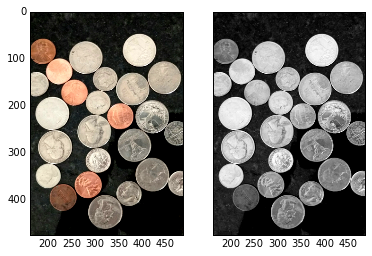

In [6]:
import matplotlib.pyplot as plt
from skimage import color, feature

# 이미지 파일 불러와서, 흑백으로 변환
im = plt.imread('fig/quarters_dimes_pennies.png')
gray_im = color.rgb2gray(im)

f, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.imshow(im)
ax2.imshow(gray_im, cmap='gray')

동전이 배경보다 밝기 때문에 코인에 대한 마스크(mask)를 생성하는 것은 바로 가능하다.

### 2. 한계값 설정

흑백이미지에 대한 한계값 설정을 하는데 필요한, 2치화 마스크를 생성한다. 히스토그램을 사용하거나 절절한 한계값(threshold)를 찾아내는데 필터를 함께 사용해서 추측하고 맞추기를 수차례 반복한다.

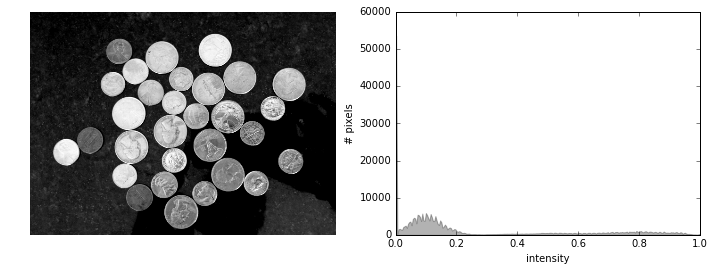

In [33]:
import skdemo

skdemo.imshow_with_histogram(gray_im);

`skdemo` 라이브러리 `imshow_with_histogram` 메쏘드를 통해 보면 대부분의 검정색 이미지와 더불어 밝은 이미지가 존재함을 확인할 수 있다. `intensity` 02~0.4 사이값을 잘라도 좋아보인다.

한계값  0.286331893943


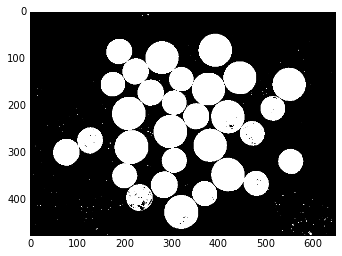

In [35]:
# -*- coding: utf-8 -*-
from skimage.filters import threshold_li

coin_thresh = threshold_li(gray_im)

print("한계값 ", coin_thresh)

coin_mask = gray_im > coin_thresh
plt.imshow(coin_mask, cmap='gray');

`skimage.filters`의 자동 한계값 찾아내는 기능을 사용해서 0.29를 한계값으로 삼아 동전이미지 마스크를 생성한다.

### 3. 마스크 정제

생성된 마스크에 일부 잡음이 끼여 있다. 모폴로지 연산자를 사용해서 마스크를 정제한다. 완벽하지는 않지만 작은 얼룩과 반점을 많이 제거할 수 있다.

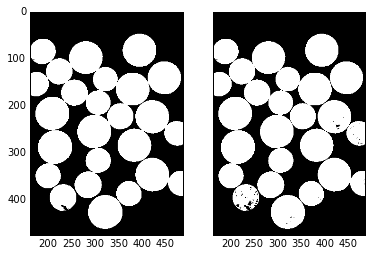

In [47]:
from skimage import morphology
from skimage.morphology import disk

coin_mask_clean = morphology.remove_small_objects(coin_mask)
coin_mask_clean = ~morphology.remove_small_objects(~coin_mask_clean)

coin_mask_clean01 = morphology.remove_small_objects(coin_mask)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.imshow(coin_mask_clean)
ax2.imshow(coin_mask_clean01)

### 4. 마스크 적용

배경을 검정색으로 설정하면 편리하다. 위에서 생성한 동전 마스크를 사용해서 최초 색상이미지와 흑백이미지 모두 배경을 0으로 설정해서 검정색을 적용시킨다.

동전은 색상이 있는 반면 그와 대비되는 배경은 검정색이다. 흑백도 동일하게 적용시킨다. 이제부터 배경이 마스크처리 되었기 때문에 배경에 대해 신경꺼도 좋다.

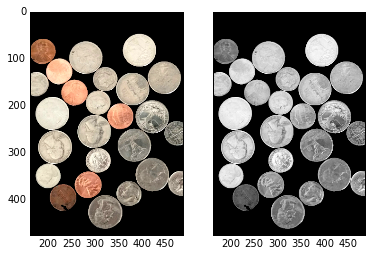

In [40]:
bg_mask = ~coin_mask_clean

im[bg_mask] = 0
gray_im[bg_mask] = 0

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.imshow(im)
ax2.imshow(gray_im)

이제 이미지에서 동전과 배경을 절단했기 때문에, 동전 각각을 식별해본다.

### 5. 분수령 세분화

분수령기반 세분화(Watershed-based segmentation)를 사용해서 동전에 표식을 생성하고 나서, 이미지 나온 동전 갯수가 몇개인지 출력한다.

이미지에 나온 동전갯수:  43 개


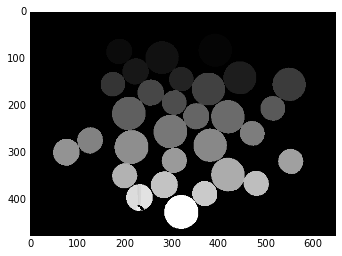

In [50]:
from scipy import ndimage as ndi
from skimage import measure
import numpy as np
#from BKlib import print_image_properties

def watershed_segmentation(mask):
    distance_im = ndi.distance_transform_edt(mask)
    peaks = feature.peak_local_max(distance_im, indices=True)
    peaks_im = np.zeros(distance_im.shape, dtype=bool)
    for row, col in peaks:
        peaks_im[row, col] = 1
    markers_im = measure.label(peaks_im)
    labelled_im = morphology.watershed(-distance_im, markers_im, mask=coin_mask_clean)
    return labelled_im


labelled_coin_im = watershed_segmentation(coin_mask_clean)

print("이미지에 나온 동전갯수: ", (len(np.unique(labelled_coin_im)) - 1), "개")
plt.imshow(labelled_coin_im);

### 6. 동전 크기 정량화 및 화면에 표시

자세한 사항은 `scikit-image` 라이브러리 `regionprops` 함수를 참조한다. 동전 중심점과 영역을 계산하는데 
표식이 붙은 동전 이미지를 사용한다. 동전이미지를 화면에 표시하고 `matplotlib` 라이브러리 `text` 기능을 사용해서 동전 중심점에 동전 각각의 면적을 출력한다.

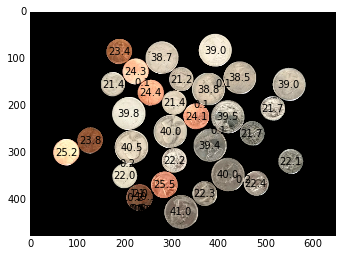

In [51]:
regions = measure.regionprops(labelled_coin_im)

plt.imshow(im)

for region in regions:
    y, x = region.centroid
    area = region.area
    area_str = '%.1f' % (area/100)
    plt.text(x, y, area_str, color='k', ha='center', va='center')  # ha, va = horizontal alignment,vertical aligment

### 7. 동전을 크기별로 구분하고 갯수를 센다.

동전을 해당 동전 기본 크기별로 구분하는 것이 가능하다. 시행착오를 통해 동전액면가를 결정하는데 동전영역정보를 활용한다. 각 동전별로 액면가 기준 갯수를 세고 나서 전체 동전 총합을 출력한다.

Quarters:  12 
Dimes:  24 
Pennies:  7
동전 총합: $ 5.47


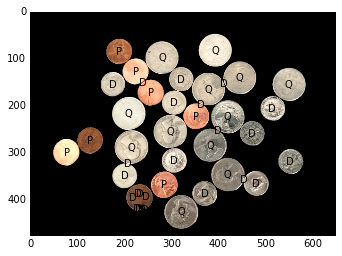

In [57]:
# I got these thresholds by examining area-labeled plot (and by trial-and-error) 
max_dime_area = 2300
min_quarter_area = 3800

num_dimes = 0
num_quarters = 0
num_pennies = 0

plt.imshow(im)

for region in regions:
    y, x = region.centroid
    area = region.area
    if area <= max_dime_area:  # small regions are dimes
        coin_name = 'D'
        num_dimes += 1
    elif area >= min_quarter_area:  # big regions are quarters
        coin_name = 'Q'
        num_quarters += 1
    else:  # everything else is pennies
        coin_name = 'P'
        num_pennies += 1
    plt.text(x, y, coin_name, ha='center', va='center')  # ha, va = horizontal alignment,vertical aligment
    
value = (25.*num_quarters + 10.*num_dimes + num_pennies)/100 
print("Quarters: ", num_quarters, "\nDimes: ", num_dimes, "\nPennies: ", num_pennies)
print("동전 총합: $", value)